# Setting up Kaggle 

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Importing Datasets

**Introduction**

There have been many terrorist attacks and lone-wolf attacks around the world. These attacks have caused immense loss of life and resources. If we can detect weapons in civilian and commercial areas through intelligent surveillance, many of these attacks can be prevented.

**Dataset collection**

This dataset is a collection of images from 9 different types of weapons. Previously, there have been datasets that has only one class Weapon or Gun. This dataset consists of 9 classes as of now: Automatic Rifle, Bazooka, Handgun, Knife, Grenade Launcher, Shotgun, SMG, Sniper, Sword. This dataset was created with the help of simple_image_download library in Python, which downloads images from internet. 100 images from each class were collected. After inspection invalid images were discarded, leaving us with a total of 714 images for all 9 classes.

**Dataset Link**
```
https://www.kaggle.com/datasets/snehilsanyal/weapon-detection-test
```



In [2]:
! kaggle datasets download snehilsanyal/weapon-detection-test
! unzip weapon-detection-test.zip

 97% 188M/194M [00:00<00:00, 277MB/s]
100% 194M/194M [00:00<00:00, 255MB/s]
Archive:  weapon-detection-test.zip
  inflating: metadata.csv            
  inflating: test/test/army.jpg      
  inflating: test/test/giphy.gif     
  inflating: test/test/mafia-mafia-game.gif  
  inflating: test/test/terrorists.jpg  
  inflating: test/test/terrorists2.jpg  
  inflating: test/test/weapons.jpg   
  inflating: test/test/weapons2.jpg  
  inflating: test/test/weaponsgta5.gif  
  inflating: weapon_detection/train/images/Automatic Rifle_10.jpeg  
  inflating: weapon_detection/train/images/Automatic Rifle_100.jpeg  
  inflating: weapon_detection/train/images/Automatic Rifle_11.jpeg  
  inflating: weapon_detection/train/images/Automatic Rifle_12.jpeg  
  inflating: weapon_detection/train/images/Automatic Rifle_14.jpeg  
  inflating: weapon_detection/train/images/Automatic Rifle_15.png  
  inflating: weapon_detection/train/images/Automatic Rifle_16.png  
  inflating: weapon_detection/train/images/Autom

# Importing Libraries

In [3]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import shutil
import random
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, r2_score
import os
import glob
import gc
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
%matplotlib inline
import warnings, cv2
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from keras.models import Sequential, load_model
from keras.regularizers import l2
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Folder Structure Creation

In [4]:
image_directory = '/content/weapon_detection/train/images/'
os.mkdir('/content/weapon_detection/train/images/gun/')
os.mkdir('/content/weapon_detection/train/images/nogun/')
for filename in os.listdir(image_directory):
    if filename.endswith('.jpeg') or filename.endswith('.png'):
        class_name = filename.split('_')[0]
        src_path ='/content/weapon_detection/train/images/'+filename
        folder=''
        if class_name=='Automatic Rifle' or class_name=='Grenade Launcher' or class_name=='Bazooka' or class_name=='Handgun' or class_name=='Shotgun' or class_name=='SMG' or class_name=='Sniper':
          folder='gun/' 
        else:
          folder='nogun/'
        dest_path='/content/weapon_detection/train/images/'+folder+filename
        shutil.move(src_path, dest_path)


Let's repeat the same for validation folder

In [5]:
image_directory = '/content/weapon_detection/val/images/'
os.mkdir('/content/weapon_detection/val/images/gun/')
os.mkdir('/content/weapon_detection/val/images/nogun/')
for filename in os.listdir(image_directory):
    if filename.endswith('.jpeg') or filename.endswith('.png'):
        class_name = filename.split('_')[0]
        src_path ='/content/weapon_detection/val/images/'+filename
        folder=''
        if class_name=='Automatic Rifle' or class_name=='Grenade Launcher' or class_name=='Bazooka' or class_name=='Handgun' or class_name=='Shotgun' or class_name=='SMG' or class_name=='Sniper':
          folder='gun/' 
        else:
          folder='nogun/'
        dest_path='/content/weapon_detection/val/images/'+folder+filename
        shutil.move(src_path, dest_path)

# Data Preprocessing 

In [14]:
gun_dir_train = Path(r'/content/weapon_detection/train/images/gun')
nogun_dir_train = Path(r'/content/weapon_detection/train/images/nogun')
gun_dir_val = Path(r'/content/weapon_detection/val/images/gun')
nogun_dir_val = Path(r'/content/weapon_detection/train/images/nogun')

In [15]:
def generate_df(img_dir, label):
    file_Path = pd.Series(list(img_dir.glob('*.*')), name='File_Path').astype(str)
    labels = pd.Series(label, name='Label', index=file_Path.index)
    df = pd.concat([file_Path, labels], axis=1)
    return df

In [16]:
gun_df_train = generate_df(gun_dir_train, 'gun')
nogun_df_train = generate_df(nogun_dir_train, 'nogun')
gun_df_val = generate_df(gun_dir_val, 'gun')
nogun_df_val = generate_df(nogun_dir_val, 'nogun')

In [17]:
all_df_train = pd.concat([gun_df_train , nogun_df_train ], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)
all_df_train.head()

,File_Path,Label
0,/content/weapon_detection/train/images/gun/Aut...,gun
1,/content/weapon_detection/train/images/gun/Aut...,gun
2,/content/weapon_detection/train/images/nogun/S...,nogun
3,/content/weapon_detection/train/images/gun/Gre...,gun
4,/content/weapon_detection/train/images/gun/Sni...,gun


In [18]:
all_df_val = pd.concat([gun_df_val , nogun_df_val ], axis=0).sample(frac=1, random_state=1).reset_index(drop=True)
all_df_val.head()

,File_Path,Label
0,/content/weapon_detection/train/images/nogun/K...,nogun
1,/content/weapon_detection/train/images/nogun/S...,nogun
2,/content/weapon_detection/val/images/gun/Autom...,gun
3,/content/weapon_detection/val/images/gun/SMG_8...,gun
4,/content/weapon_detection/train/images/nogun/S...,nogun


# Data Visualization

In [19]:
len(all_df_train)

571

Text(0.5, 1.0, 'Gun and No Gun')

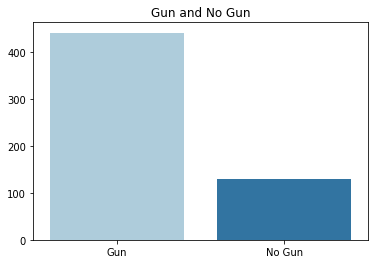

In [20]:
sns.barplot(x=['Gun','No Gun'], y=[len(gun_df_train), len(nogun_df_train)], palette='Paired' )
plt.title('Gun and No Gun')

Text(0.5, 1.0, 'Training Data vs Validation Data')

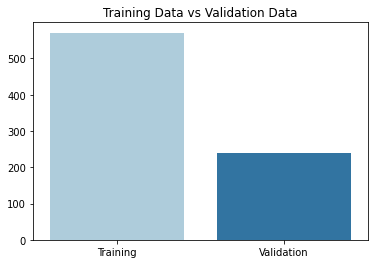

In [21]:
sns.barplot(x=['Training','Validation'], y=[len(all_df_train), len(all_df_val)], palette='Paired' )
plt.title('Training Data vs Validation Data')

# Image Preprocessing

In [22]:
from keras.preprocessing.image import ImageDataGenerator
train_gen = ImageDataGenerator(rescale = 1.0/255.0) 
train_image_generator = train_gen.flow_from_directory(
                                            '/content/weapon_detection/train/images/',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='binary')
val_gen = ImageDataGenerator(rescale = 1.0/255.0) 
val_image_generator = val_gen.flow_from_directory(
                                            '/content/weapon_detection/val/images',
                                            target_size=(224, 224),
                                            batch_size=32,
                                            class_mode='binary')

Found 571 images belonging to 2 classes.
Found 143 images belonging to 2 classes.


# Creating CNN Model

In [26]:
model = Sequential()
model.add(Conv2D(64,3,padding="same", activation="relu",input_shape=(224,224,3)))
model.add(MaxPooling2D())

model.add(Conv2D(64, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Conv2D(128, 3, padding="same", activation="relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(256,activation="relu",kernel_regularizer=l2(0.001)))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(Dense(1, activation="sigmoid"))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 64)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 128)     

In [27]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics='accuracy')

In [29]:
checkpoint_filename = 'checkpoint/'
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filename,monitor='val_accuracy',verbose=1,save_best_only=True,save_weights_only=True,mode='max')

r = model.fit(train_image_generator,
            epochs=20,
            batch_size=32,
            validation_data=val_image_generator,
            callbacks=[model_checkpoint])
gc.collect()

Epoch 1/20
18/18 [==============================] - ETA: 0s - loss: 1.1655 - accuracy: 0.7566
Epoch 1: val_accuracy improved from -inf to 0.76923, saving model to checkpoint/
18/18 [==============================] - 25s 1s/step - loss: 1.1655 - accuracy: 0.7566 - val_loss: 1.0817 - val_accuracy: 0.7692
Epoch 2/20
18/18 [==============================] - ETA: 0s - loss: 1.0123 - accuracy: 0.8091
Epoch 2: val_accuracy improved from 0.76923 to 0.77622, saving model to checkpoint/
18/18 [==============================] - 22s 1s/step - loss: 1.0123 - accuracy: 0.8091 - val_loss: 1.2528 - val_accuracy: 0.7762
Epoch 3/20
18/18 [==============================] - ETA: 0s - loss: 0.8622 - accuracy: 0.8459
Epoch 3: val_accuracy did not improve from 0.77622
18/18 [==============================] - 20s 1s/step - loss: 0.8622 - accuracy: 0.8459 - val_loss: 1.0506 - val_accuracy: 0.7762
Epoch 4/20
18/18 [==============================] - ETA: 0s - loss: 0.7505 - accuracy: 0.8914
Epoch 4: val_accuracy

1520

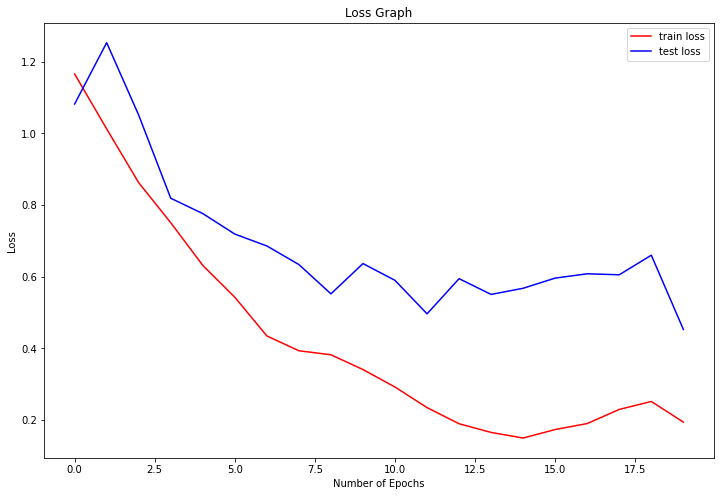

In [30]:
plt.figure(figsize=(12,8))
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.title('Loss Graph')
plt.legend();

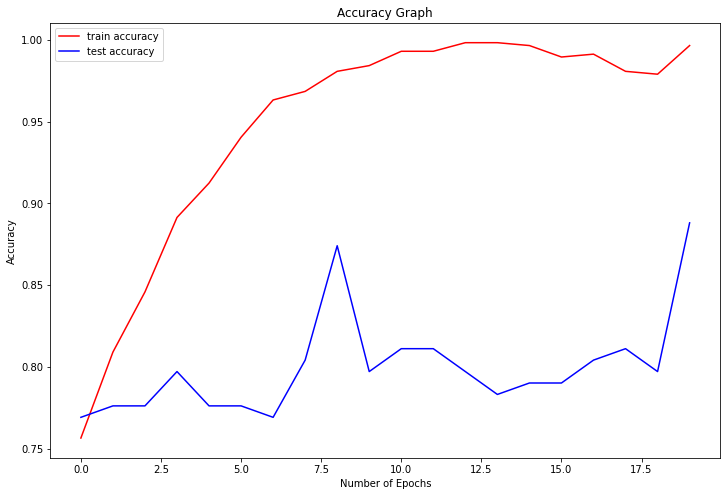

In [31]:
plt.figure(figsize=(12,8))
plt.plot(r.history['accuracy'],'r',label='train accuracy')
plt.plot(r.history['val_accuracy'],'b',label='test accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Graph')
plt.legend();